In [34]:
import argparse
import numpy as np
import os
import torch
import random
from utils import *
import matplotlib.pyplot as plt
from collections import OrderedDict
from get_data import *

# x = np.linspace(0, 2.8, 280, endpoint=True).reshape(-1,1) # not inclusive
# t = np.linspace(0, 5, 300, endpoint=True).reshape(-1,1)

# X, T = np.meshgrid(x, t) # all the X grid points T times, all the T grid points X times
# X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None])) #all the x,t points not inclusive

# #remove initial and boundary data from X_star


# t_no_intial = t[1:]

# #remove boundary at x = 0
# x_no_boundary = x[1:]

# X_NB, T_NI = np.meshgrid(x_no_boundary, t_no_intial)
# X_star_NB = np.hstack((X_NB.flatten()[:, None], T_NI.flatten()[:, None]))


# # Sample collocation points only from the interior (Where the PDE is enforce)
# # Number of collocation points
# N_c = 74
# set_seed(0)
# X_f_train = sample_random(X_star_NB, N_c)
X_f_train = fetch_boundary_spatial_temporal()

# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('cuda')
else:
    device = torch.device('cpu')
    print('cpu')

cpu


In [45]:
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 2): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            # layer_list.append(('dropout_%d' %i, torch.nn.Dropout(p=0.5)))

        layer_list.append(
                ('layer_%d' % (self.depth - 2), torch.nn.Linear(layers[-3], layers[-2]))
            )
        layer_list.append(('activation_%d' % (self.depth - 2), torch.nn.ReLU()))    
        
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )

        layer_list.append(('activation_%d' % (self.depth - 1), torch.nn.ReLU()))
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        product = self.layers(x)
        product_eps = product + 1e-6

        return product_eps



# the physics-guided neural network


class PhysicsInformedNN():
    def __init__(self, X_u, X_f, layers):
        
        torch.manual_seed(1234)
        
        self.x_u = X_u[:, 0].unsqueeze(-1).to(torch.float32)
        self.t_u = X_u[:, 1].unsqueeze(-1).to(torch.float32)
        self.u_u = X_u[:, 2].unsqueeze(-1).to(torch.float32)


        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        # self.x_f = X_f[:, 0].unsqueeze(-1).to(torch.float32)
        # self.t_f = X_f[:, 1].unsqueeze(-1).to(torch.float32)
        
        self.layers = layers

        self.dnn = DNN(layers).to(device)
        for layer in self.dnn.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

        
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), lr = 0.001, weight_decay=0.001)
        # self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), lr = 0.001)
        self.iter = 0
        
    def net_u(self, x, t):
        x = x.requires_grad_()
        t = t.requires_grad_()
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        # lambda_1 = self.lambda_1        
        # lambda_2 = torch.exp(self.lambda_2)

        #return the approximated u given x and t
        V_f = 16.6
        u = self.net_u(x, t)

        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        
        temp_u = ((u*u/2)*(1/2 + torch.log(u/V_f)))
        u_x = torch.autograd.grad(
            temp_u, x, 
            grad_outputs=torch.ones_like(temp_u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + u_x

        return f
    


    # def loss_func(self):
    #     alpha  = 0
    #     u_pred = self.net_u(self.x, self.t)
    #     f_pred = self.net_f(self.x, self.t)
    #     loss = torch.mean((self.u - u_pred) ** 2) + alpha*torch.mean(f_pred ** 2)
    #     self.optimizer.zero_grad()
    #     loss.backward()
        
    #     self.iter += 1
    #     if self.iter % 100 == 0:
    #         print(
    #             'Loss: %e' % 
    #             (
    #                 loss.item(), 
                   
    #             )
    #         )
    #     return loss





    def train(self, nIter):

        min_loss = 1e6
        current_loss = 0
        all_losses = []
        plot_steps, print_steps = 100, 5000
        n_iters = nIter
        #self.dnn.train()
        for epoch in range(nIter):
            
            u_pred = self.net_u(self.x_u, self.t_u)            
            f_pred = self.net_f(self.x_f, self.t_f)

            pde_loss = torch.mean(f_pred ** 2)    
            mse_loss = torch.mean((self.u_u - u_pred) ** 2)
            
            loss =   mse_loss + pde_loss
            
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()

            current_loss = current_loss + mse_loss.item()
            # if loss < min_loss:
            #     min_loss = loss
            #     torch.save(self.dnn, 'Best_weights_pde.pt')
            MSE_F = mse_loss.item()
            if epoch % 100 == 0:
                
                print(
                    'It: %d, Loss: %.3e , Pde_LOSS: %.3e' % 
                    (
                        epoch, 
                        mse_loss.item(),
                        pde_loss.item()
                       
                    )
                )
    
                all_losses.append(current_loss / plot_steps)
                current_loss = 0
            
        plt.figure()
        all_losses.pop(0)
        plt.plot(all_losses)
        plt.title("Training loss")
        plt.xlabel("Epoch")
        plt.ylabel("MSE Loss")
        plt.show()
        # self.optimizer.step(self.loss_func)
        
    
    def predict(self, X):
        
        x = X[:, 0].unsqueeze(-1).to(torch.float32)
        t = X[:, 1].unsqueeze(-1).to(torch.float32)
       
        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        mask = u > 16.6
        u[mask] = 16.6
    
        f = f.detach().cpu().numpy()
        return u

    def save_model(self):
        final = self.dnn
        return final

In [46]:
#get the data inplace
XT_u_tensor = fetch_data_wo_b(100)


/tmp/ipykernel_2491143/233868991.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
/tmp/ipykernel_2491143/233868991.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)


It: 0, Loss: 1.406e+02 , Pde_LOSS: 1.686e-04
It: 100, Loss: 1.647e+01 , Pde_LOSS: 1.542e+00
It: 200, Loss: 1.465e+01 , Pde_LOSS: 2.315e-01
It: 300, Loss: 1.457e+01 , Pde_LOSS: 7.256e-02
It: 400, Loss: 1.446e+01 , Pde_LOSS: 4.352e-02
It: 500, Loss: 1.441e+01 , Pde_LOSS: 3.003e-02
It: 600, Loss: 1.436e+01 , Pde_LOSS: 1.475e-02
It: 700, Loss: 1.429e+01 , Pde_LOSS: 9.487e-03
It: 800, Loss: 1.425e+01 , Pde_LOSS: 7.327e-03
It: 900, Loss: 1.420e+01 , Pde_LOSS: 7.822e-03
It: 1000, Loss: 1.418e+01 , Pde_LOSS: 7.444e-03
It: 1100, Loss: 1.416e+01 , Pde_LOSS: 3.687e-03
It: 1200, Loss: 1.414e+01 , Pde_LOSS: 1.093e-03
It: 1300, Loss: 1.413e+01 , Pde_LOSS: 1.363e-03
It: 1400, Loss: 1.413e+01 , Pde_LOSS: 2.963e-03
It: 1500, Loss: 1.412e+01 , Pde_LOSS: 3.618e-03
It: 1600, Loss: 1.411e+01 , Pde_LOSS: 4.352e-03
It: 1700, Loss: 1.409e+01 , Pde_LOSS: 9.427e-03
It: 1800, Loss: 1.405e+01 , Pde_LOSS: 4.809e-03
It: 1900, Loss: 1.400e+01 , Pde_LOSS: 4.806e-03
It: 2000, Loss: 1.396e+01 , Pde_LOSS: 2.111e-03
It: 

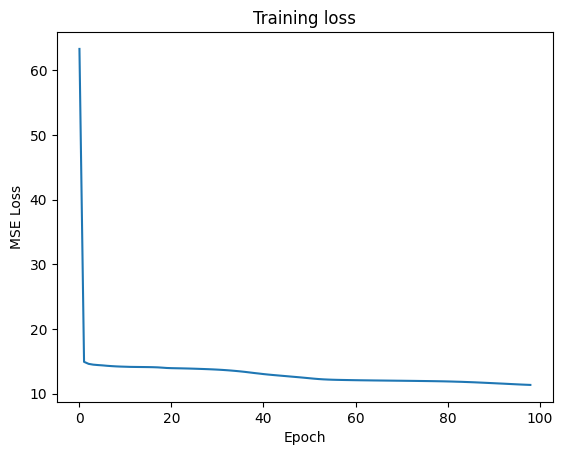

In [48]:
layers = [2, 47, 47, 47, 1]
model = PhysicsInformedNN(XT_u_tensor, X_f_train, layers)
model.train(10000)

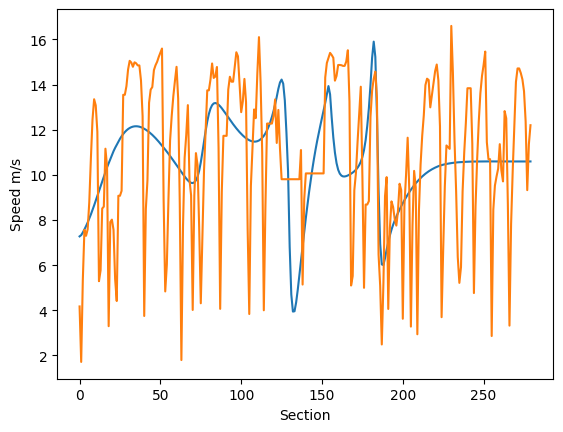

In [52]:
x_test = np.linspace(0, 2.8, 280)
# t = [0.2 for i in range(280)]
# t = np.array(t)

# xt_test = np.hstack((x_test.flatten()[:, None], t.flatten()[:, None]))
# xt_test = torch.tensor(xt_test)



test_v, time_t = fetch_test(1)
time_t = np.array(time_t).reshape(-1, 1)
test_v = np.array(test_v)
xt_test = np.hstack((x_test.flatten()[:, None], time_t.flatten()[:, None]))
xt_test = torch.tensor(xt_test)
pred = model.predict(xt_test)

plt.xlabel("Section")
plt.ylabel("Speed m/s")
plt.plot(pred)
plt.plot(test_v)

In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

aa = mean_absolute_error(test_v, pred)
print(aa)
aa = mean_squared_error(test_v, pred)
print(aa)

2.576846875333098
10.136831282780129
